In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

In [ ]:
def load_video(video_path, resize_dim=(320, 240)):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame for faster processing
        resized_frame = cv2.resize(frame, resize_dim)
        frames.append(resized_frame)

    cap.release()
    return frames

In [ ]:
def convert_to_hsv(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

In [ ]:
def noise_detection(frame):
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    noise_mask = cv2.absdiff(frame, blurred)
    return noise_mask

In [ ]:
def histogram_comparison(frame1, frame2):
    hist1 = cv2.calcHist([frame1], [0, 1], None, [256, 256], [0, 256, 0, 256])
    hist2 = cv2.calcHist([frame2], [0, 1], None, [256, 256], [0, 256, 0, 256])
    cv2.normalize(hist1, hist1, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist2, hist2, 0, 1, cv2.NORM_MINMAX)


    similarity_score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity_score

In [ ]:
def sobel_edge_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale before Sobel
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edges = cv2.magnitude(sobel_x, sobel_y)
    return np.uint8(edges)


In [ ]:
def find_least_similarity_cuts(similarity_scores, frames, top_n=5):
    # Get the indices of the least similarity scores (lowest values indicate scene cuts)
    least_similar_indices = np.argsort(similarity_scores)[:top_n]

    print(f"Top {top_n} scene cut frames (by least similarity):")
    for i, idx in enumerate(least_similar_indices):
        print(f"Scene cut {i+1}: between frame {idx} and frame {idx+1} with similarity score: {similarity_scores[idx]}")

        # Display the two consecutive frames where the scene cut occurs
        cv2_imshow(frames[idx])
        cv2_imshow(frames[idx+1])
        cv2.waitKey(1000)  # Wait for a key press to display next set of frames

    return least_similar_indices

In [ ]:
def process_video(video_path, hsv_directory, noise_directory, edge_directory, top_n_cuts=5, resize_dim=(320, 240)):
    if not os.path.exists(hsv_directory):
        os.makedirs(hsv_directory)
    if not os.path.exists(noise_directory):
         os.makedirs(noise_directory)
    if not os.path.exists(edge_directory):
         os.makedirs(edge_directory)

    frames = load_video(video_path, resize_dim=resize_dim)
    hsv_frames = []
    noise_frames = []
    edge_frames = []
    similarity_scores = []
    for idx, frame in enumerate(frames):
        #  Convert each frame into HSV
        hsv_frame = convert_to_hsv(frame)
        hsv_frames.append(hsv_frame)
        cv2.imwrite(os.path.join(hsv_directory, f'hsv_frame_{idx}.png'), hsv_frame)

        #  Detect noise
        noise_frame = noise_detection(frame)
        noise_frames.append(noise_frame)
        cv2.imwrite(os.path.join(noise_directory, f'noise_frame_{idx}.png'), noise_frame)

        #  Perform histogram comparison with the previous frame
        if idx > 0:
            similarity = histogram_comparison(frames[idx-1], frames[idx])
            similarity_scores.append(similarity)
            print(f'Similarity between frame {idx-1} and frame {idx}: {similarity}')

        # : Perform edge detection
        edge_frame = sobel_edge_detection(frame)
        edge_frames.append(edge_frame)
        cv2.imwrite(os.path.join(edge_directory, f'edge_frame_{idx}.png'), edge_frame)

    #  Find least similarity cuts and display the frames
    if len(similarity_scores) > 0:
        least_similar_indices = find_least_similarity_cuts(similarity_scores, frames, top_n_cuts)

        # Optionally, save the frames at the scene cut points for analysis
        for i, idx in enumerate(least_similar_indices):
            cv2.imwrite(os.path.join(hsv_directory, f'scene_cut_frame_{i+1}frame{idx}.png'), frames[idx])
            cv2.imwrite(os.path.join(hsv_directory, f'scene_cut_frame_{i+1}frame{idx+1}.png'), frames[idx+1])

Similarity between frame 0 and frame 1: 0.9995100939610976
Similarity between frame 1 and frame 2: 0.9995903362190776
Similarity between frame 2 and frame 3: 0.9995105230526433
Similarity between frame 3 and frame 4: 0.9995158079607508
Similarity between frame 4 and frame 5: 0.9994500970210826
Similarity between frame 5 and frame 6: 0.9994629421983999
Similarity between frame 6 and frame 7: 0.9993116468191838
Similarity between frame 7 and frame 8: 0.9992856254394112
Similarity between frame 8 and frame 9: 0.9995250517328764
Similarity between frame 9 and frame 10: 0.9995911405553297
Similarity between frame 10 and frame 11: 0.9985751894966203
Similarity between frame 11 and frame 12: 0.9993535475624663
Similarity between frame 12 and frame 13: 0.9996630521418772
Similarity between frame 13 and frame 14: 0.9996477367433366
Similarity between frame 14 and frame 15: 0.9997876444796354
Similarity between frame 15 and frame 16: 0.9996727224097319
Similarity between frame 16 and frame 17: 0

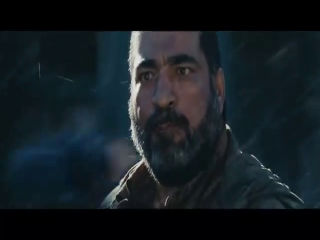

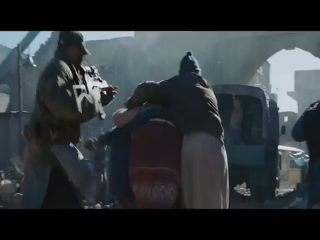

Scene cut 2: between frame 895 and frame 896 with similarity score: 0.85682649955038


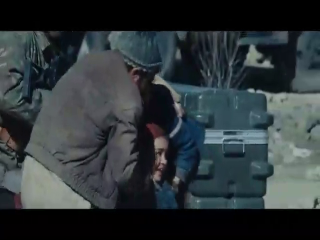

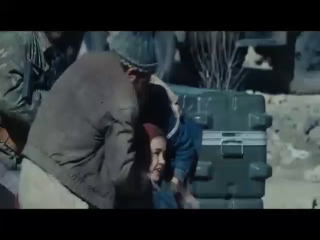

Scene cut 3: between frame 235 and frame 236 with similarity score: 0.9414558201108666


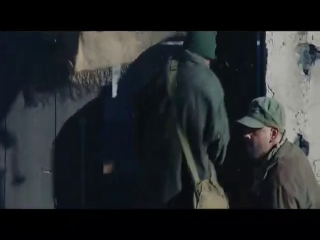

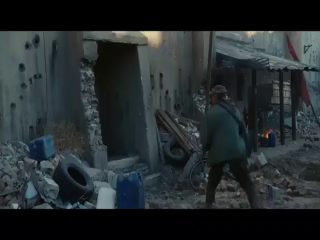

Scene cut 4: between frame 127 and frame 128 with similarity score: 0.9467800884352373


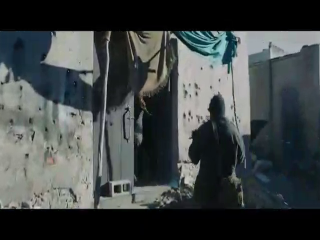

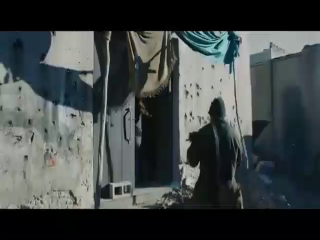

Scene cut 5: between frame 953 and frame 954 with similarity score: 0.948854597872939


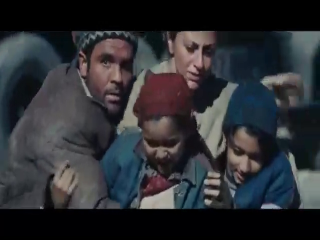

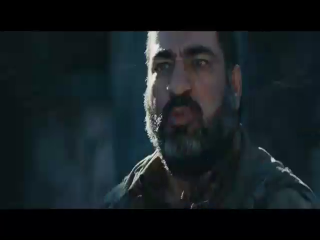

Scene cut 6: between frame 255 and frame 256 with similarity score: 0.9500131877250585


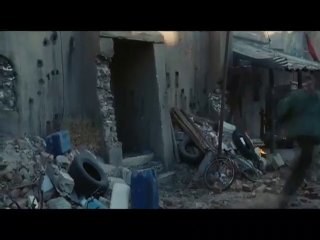

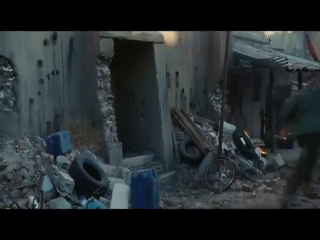

Scene cut 7: between frame 176 and frame 177 with similarity score: 0.9574197962458071


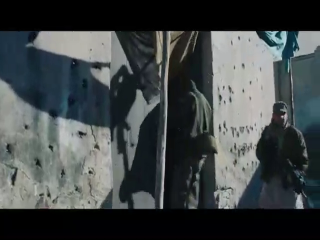

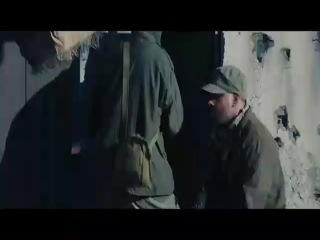

Scene cut 8: between frame 520 and frame 521 with similarity score: 0.9675198225042093


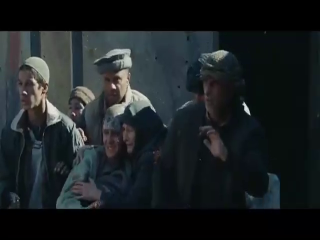

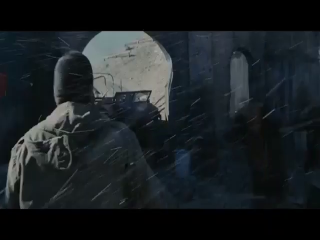

Scene cut 9: between frame 1040 and frame 1041 with similarity score: 0.9693950890063061


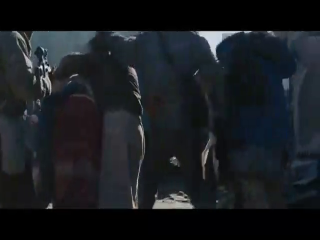

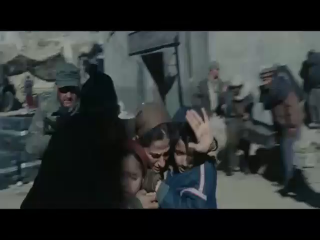

Scene cut 10: between frame 1023 and frame 1024 with similarity score: 0.9711508323366463


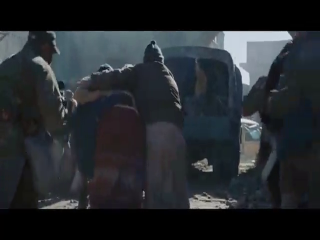

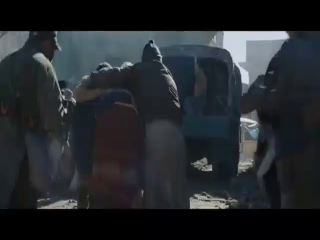

In [ ]:
video_path = r"/content/samplevideo2.mp4"
hsv_directory = r"/content/hsv_frames"
noise_directory = r"/content/noise_frames"
edge_directory = r"/content/edge_frames"
process_video(video_path, hsv_directory, noise_directory, edge_directory, top_n_cuts=10, resize_dim=(320, 240))

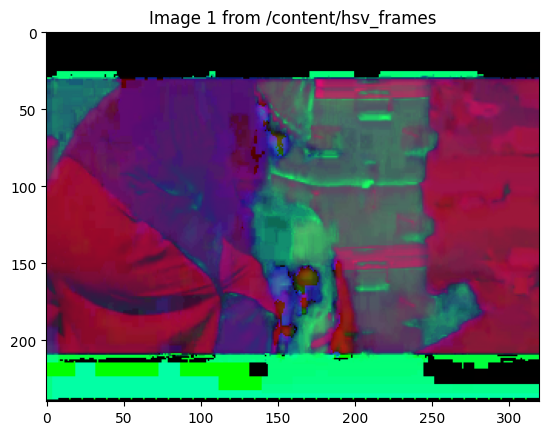

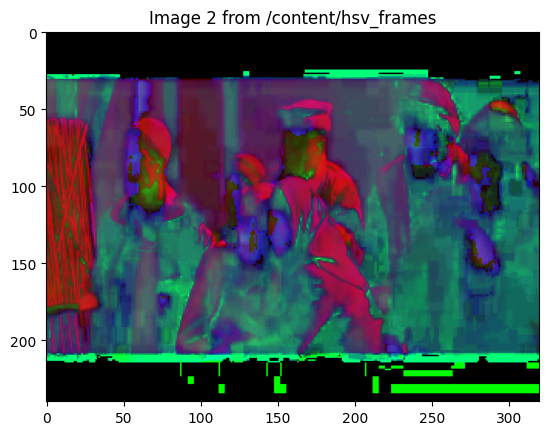

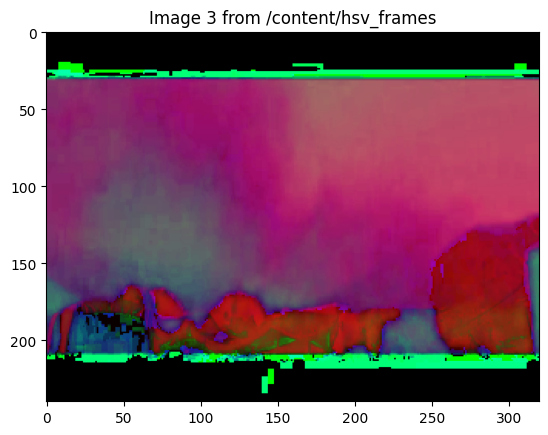

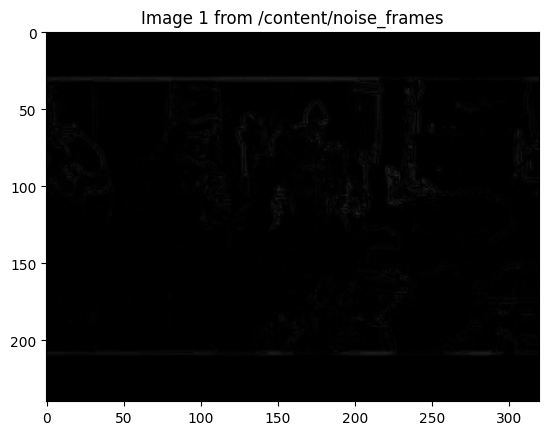

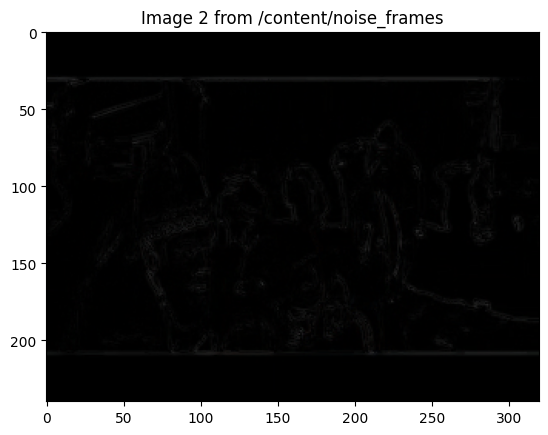

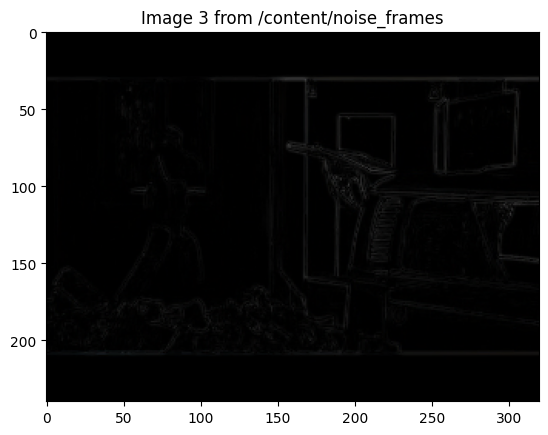

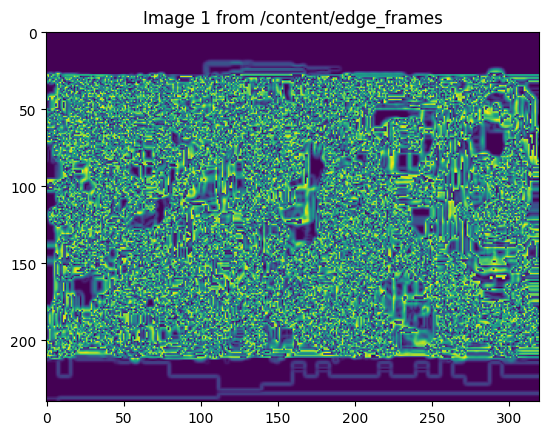

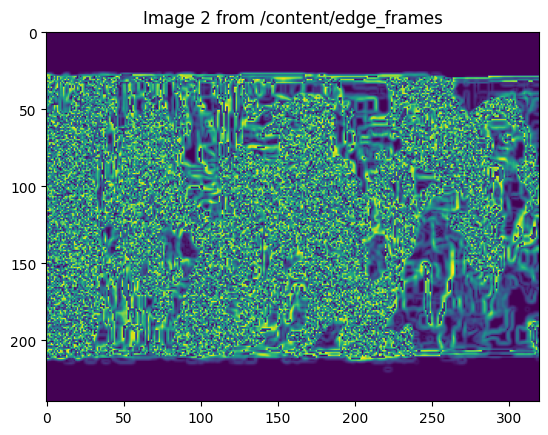

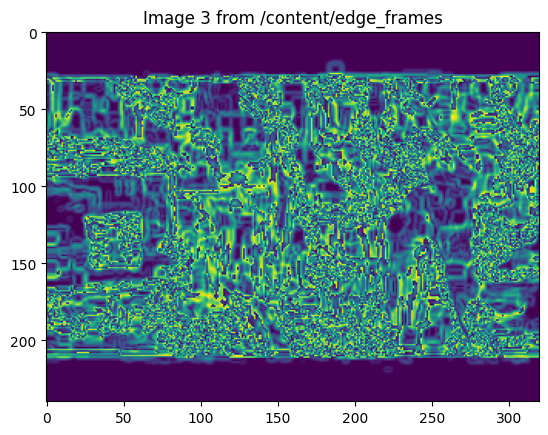

In [ ]:
import matplotlib.pyplot as plt
import os

def display_images_from_folder(folder_path, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if not image_files:
        print(f"No images found in {folder_path}")
        return

    for i in range(min(num_images, len(image_files))):
        image_path = os.path.join(folder_path, image_files[i])
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.title(f"Image {i+1} from {folder_path}")
        plt.show()

# Display a few HSV frames
display_images_from_folder("/content/hsv_frames", num_images=3)

# Display a few noise frames
display_images_from_folder("/content/noise_frames", num_images=3)

# Display a few edge frames
display_images_from_folder("/content/edge_frames", num_images=3)